# Basic pre-processing pipeline

The following is the minimal preprocessing pipeline to be applied to EMGs for analysis. This is meant to create the EMG that all other pre-processing steps are added over

## Import libraries

In [1]:
# %matplotlib widget
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import math
# IMPORT Ole's fixed TMSiSDK python interface
sys.path.insert(0,'C:/Projects/tmsi-python-interface')
from TMSiSDK.file_readers import Poly5Reader

sys.path.insert(0, '../resurfemg')
import helper_functions as hf

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [2]:
# load up sample EEGs to show results
big_data_list= []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

In [3]:
root_emg_directory = os.path.join('../not_pushed','topspin_data_anonymized')

In [4]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)


Now you can pick a file from the list, which have been numbered 0-35.

In [5]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))

btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

In [6]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen]
print(file_chosen)

../not_pushed\topspin_data_anonymized\M001\006\EMG_recording.Poly5


In [7]:
data_emg = Poly5Reader(file_chosen)
data_samples = data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)

Reading file  ../not_pushed\topspin_data_anonymized\M001\006\EMG_recording.Poly5
	 Number of samples:  762496 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


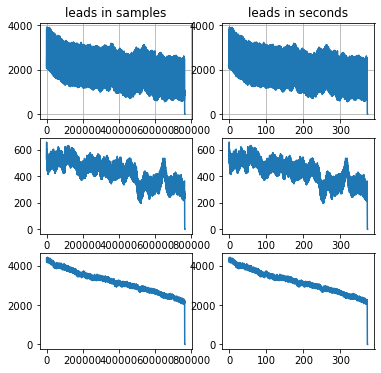

In [8]:
%matplotlib inline
# set up plot
x = data_samples
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(6, 6))
axis[0, 0].grid(True)
axis[0, 0].plot(x[0])
axis[0, 0].set(title='leads in samples')
axis[1, 0].plot(x[1])
axis[2, 0].plot(x[2])
axis[0, 1].set(title='leads in seconds')
axis[0, 1].grid(True)
axis[0, 1].plot(converted_to_seconds, x[0])
axis[1, 1].plot(converted_to_seconds, x[1])
axis[2, 1].plot(converted_to_seconds, x[2])

That is the whole unfiltered EMG, now we want a basic preprocessing pipeline that gives us the EMG signal.

In [9]:
# y_axis = widgets.Dropdown(
#     options=["Samples", "Seconds"],
#     value='Samples',
#     description="Select View Option",
#     disabled=False,
# )
# display(y_axis)

Dropdown(description='Select View Option', options=('Samples', 'Seconds'), value='Samples')

In [10]:
# time_view = y_axis.value
# time_view

'Samples'

In [11]:
# type in start number and press return for it to update
# start = input()

0


In [20]:
# # type in end number and press return for it to update
# end = input()

40000


In [21]:
# start_s = float(start)* emg_sample_rate
# end_s = float(end)*emg_sample_rate

In [9]:
# if time_view == 'Samples':
#     # nox examine at a certain scale- from point a to b as samples
#     x = data_samples
#     fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, figsize=(6, 4))
#     ax_1.grid(True)
#     ax_1.plot(x[0][int(start):int(end)])
#     ax_1.set(title='leads, samples')
#     ax_2.plot(x[1][int(start):int(end)])
#     ax_3.plot(x[2][int(start):int(end)])

# if time_view == 'Seconds':
#     # nox examine at a certain scale- from point a to b as samples
#     x_for_secs = data_samples

#     #converter_for_sample_number =90

#     y = converted_to_seconds
#     fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, figsize=(6, 4))
#     ax_1.grid(True)
#     ax_1.plot(y[int(start_s):int(end_s)], x[0][int(start_s):int(end_s)])
#     ax_1.set(title='leads, seconds')
#     ax_2.plot(y[int(start_s):int(end_s)], x[1][int(start_s):int(end_s)])
#     ax_3.plot(y[int(start_s):int(end_s)], x[2][int(start_s):int(end_s)])

Let's try one example of a pipeline, which is not our pre-procesing, but we know works:

In [10]:
def working_pipeline_exp2_2(our_chosen_file):
    cut_file_data = hf.bad_end_cutter_for_samples(
        our_chosen_file, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(
        cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(
        bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the secret hidden step!
    emg = hf.pick_more_peaks_array(components)
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    #final_envelope_a = helper_functions.naive_rolling_rms(final_envelope_d, 300)
    # plt.plot(final_envelope_a[0:5000])

    return final_envelope_d

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


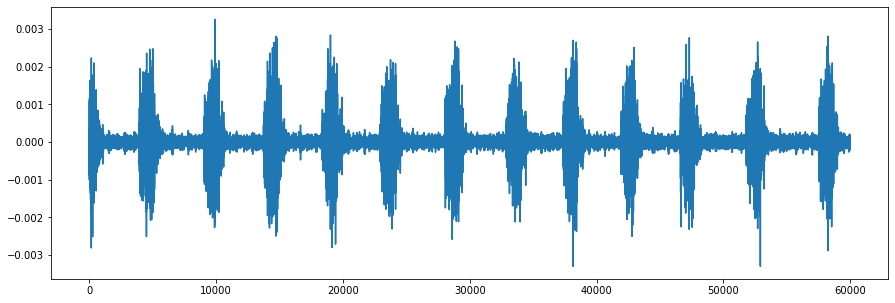

In [13]:
x = working_pipeline_exp2_2(data_samples)

start = 1
end = 60000
#if time_view == 'Samples':
plt.figure(figsize=(15, 5))
plt.plot(x[int(start):int(end)])
# else:
#     plt.figure(figsize=(15, 5))

#     plt.plot(y[int(start_s):int(end_s)], x[int(start_s):int(end_s)])

Nice. Now let's switch out the EMG picker to the one that picks the heart lead, and not do extra filtering steps that get rid of some noise.

In [36]:

def minimal_pipeline(our_chosen_file, heart_lead_number):
    cut_file_data = hf.bad_end_cutter_for_samples(
        our_chosen_file, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(
        cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(
        bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the secret hidden step!
    ecg_lead = re_cut_file_data[heart_lead_number]
    emg = hf.pick_lowest_correlation_array(components, ecg_lead)
    return emg
    

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


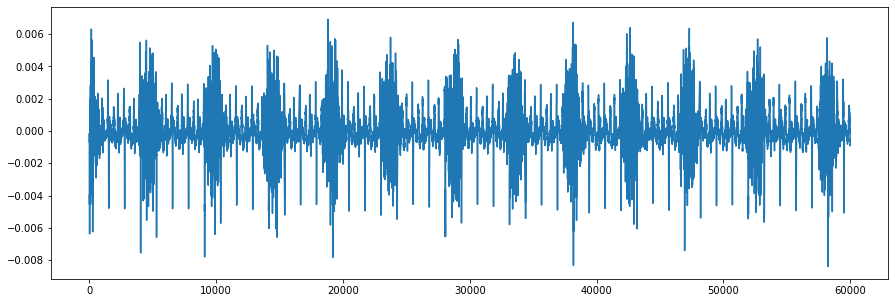

In [37]:
x = heart_lead_sim_pipeline(data_samples, 0)

start = 1
end = 60000
#if time_view == 'Samples':
plt.figure(figsize=(15, 5))
plt.plot(x[int(start):int(end)])


In [39]:
x = hf.minimal_pipeline(data_samples,2)

AttributeError: module 'helper_functions' has no attribute 'minimal_pipeline'

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


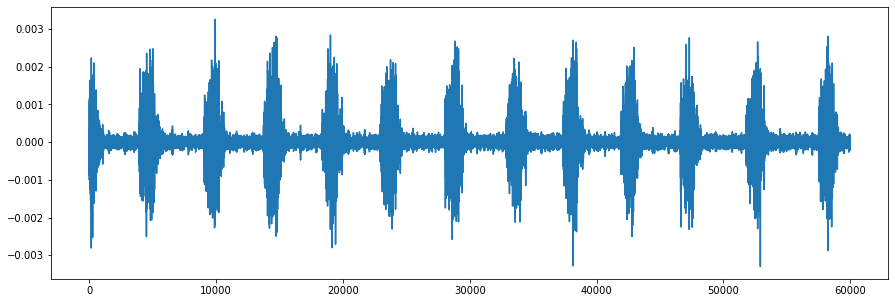

In [28]:
x = heart_lead_sim_pipeline(data_samples, 1)

start = 1
end = 60000
#if time_view == 'Samples':
plt.figure(figsize=(15, 5))
plt.plot(x[int(start):int(end)])


Now for our sample let's make a cut off and count the breaths automatically

In [26]:
if time_view == 'Samples':
    x = x[int(start):int(end)]  # we cut it down to our selection
else:
    x = x[int(start_s):int(end_s)]
abs_x = abs(x)
rms_abs = hf.vect_naive_rolling_rms(abs_x, 400)

Now let's widget try a cut from the max. If you chose seconds it will show the measurements in samples for now. We will update this code later.

In [27]:
int_slider1 = widgets.IntSlider(
    min=1, max=100, step=1,
    description='percentage of maximum'
)
widgets.VBox(
    [

        int_slider1,


    ]
)


@widgets.interact(low=int_slider1)
def update(low=int_slider1):
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.grid(True)
        [l.remove() for l in ax.lines]
        low_per = low/100
        ax.plot(hf.zero_one_for_jumps_base(
            rms_abs, rms_abs.max()*low_per), color='C0')
        ax.plot(x*1000, alpha=0.2)

interactive(children=(IntSlider(value=1, description='percentage of maximum', min=1), Output()), _dom_classes=…

In [78]:
max_per_ = int_slider1.value
max_per_ = max_per_ / 100
decision_line = hf.zero_one_for_jumps_base(rms_abs, rms_abs.max()*max_per_)
max_per_peak_count = hf.count_decision_array(decision_line)
max_per_peak_count

1.0

Looks like an improvement, but how much information did we lose?

# Storing off this experiment

I would argue we lost more noise than important 'information', but now we have a framework to start comparing information loss

Now let's save the information we just generated.

In [79]:
data_now = [file_chosen, number_chosen, start, end,
            max_per_, max_per_peak_count, my_count, time_view]

In [80]:
data_now

['../not_pushed\\topspin_data_anonymized\\M001\\007\\EMG_recording.Poly5',
 6,
 '1',
 '3',
 0.36,
 1.0,
 '1',
 'Seconds']

In [81]:
# run every time you want to append a new sample
big_data_list.append(data_now)
big_data_list

[['../not_pushed\\topspin_data_anonymized\\M002\\004\\EMG_recording.Poly5',
  12,
  '100',
  '10000',
  0.22,
  1.0,
  '1'],
 ['../not_pushed\\topspin_data_anonymized\\M002\\004\\EMG_recording.Poly5',
  12,
  '100',
  '10000',
  0.22,
  1.0,
  '1',
  'Samples'],
 ['../not_pushed\\topspin_data_anonymized\\M001\\007\\EMG_recording.Poly5',
  6,
  '1',
  '3',
  0.36,
  1.0,
  '1',
  'Seconds']]

In [82]:
columns_now = ['file_chosen',
               'number_file',
               'start_cut',
               'end_cut',
               'cut_off_percent',
               'automated_breath_count',
               'my_hand_count',
               'units',

               ]

df = pd.DataFrame(big_data_list, columns=columns_now)

In [83]:
df

,file_chosen,number_file,start_cut,end_cut,cut_off_percent,automated_breath_count,my_hand_count,units
0,../not_pushed\topspin_data_anonymized\M002\004...,12,100,10000,0.22,1.0,1,None
1,../not_pushed\topspin_data_anonymized\M002\004...,12,100,10000,0.22,1.0,1,Samples
2,../not_pushed\topspin_data_anonymized\M001\007...,6,1,3,0.36,1.0,1,Seconds


In [ ]:
df.to_csv('my_saved_experiments.csv')

You probably want to change the name to a timestamp, and save every hour. 